## Student Information

Please enter the names and IDs of the two students below:

1. **Name**: [Norhan Reda Abdelwahed Ahmed]  
   **ID**: `9203639` 

2. **Name**: [Hoda Gamal Hamouda Ismail]  
   **ID**: `9203673` 


## Students Instructions

This is your first graded lab assignment, as you put the work you have studied in the lectures in action, please take this opportunity to enhance your understanding of the concepts and hone your skills. As you work on your assignment, please keep the following instructions in mind:

- Clearly state your personal information where indicated.
- Be ready with your work before the time of the next discussion slot in the schedule.
- Plagiarism will be met with penalties, refrain from copying any answers to make the most out of the assignment. If any signs of plagiarism are detected, actions will be taken.
- It is acceptable to share the workload of the assignment bearing the discussion in mind.
- Feel free to reach out if there were any ambiguities.





## Installation Instructions

When setting up your development environment for geospatial analysis, it's crucial to install the necessary libraries correctly to avoid common issues. Here are the steps and important notes to guide you through the installation process:

1. Install GDAL
To avoid errors related to Visual Studio build files when installing GDAL via pip, it's recommended to use Conda. This method simplifies the installation process by handling binary dependencies:
```bash
conda install -c conda-forge gdal
```

1. Install EarthPy
To circumvent dependency errors that might occur when installing EarthPy with Conda, use pip. This ensures that EarthPy and its Python dependencies are installed correctly:
```bash
pip install earthpy
```

1. Pay Attention to Versioning
It's critical to select a Python version that satisfies the requirements of both GDAL, as it relates to GIS, and EarthPy. Ensuring compatibility across these libraries will prevent version conflicts and runtime errors.

1. Create a Python Environment
To avoid disrupting your base environment or the default Python distribution, create a dedicated Python or Conda environment with Python versions 3.8, 3.9, or 3.10. This isolation helps manage dependencies more effectively and keeps your system tidy:
```bash
# For Conda
conda create -n geospatial python=3.8
conda activate geospatial

# Alternatively, for Python's venv
python -m venv geospatial
# Activate the environment as per your OS instructions
```

By following these instructions, you can set up a robust geospatial analysis environment that minimizes common installation issues and fosters a productive development workflow.
```


# Image Correction and Transformation




In [1]:
##Import all needed libraries
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import earthpy.plot as ep
import earthpy.spatial as es
import cv2
import rasterio

## Bad Pixels

Numerous factors, including sensor disturbances, errors during data transmission, or potential equipment failures, can lead to the presence of erroneous pixels within satellite images. Such imperfections may compromise image integrity, thereby impacting the reliability of any subsequent analyses or interpretations derived from these images.

An effective strategy for addressing random bad pixels (values set to 0) involves utilizing an algorithm that identifies and substitutes these pixels with values reflective of their immediate surroundings. The steps for implementing this algorithm are outlined below:

1. **Detect Bad Pixels**: Start by pinpointing the bad pixels within the image. This identification can be achieved through methods like visual inspection or the use of automated detection algorithms.

2. **Establish a Neighborhood**: For each identified bad pixel, define a surrounding area or neighborhood. The extent of this neighborhood is determined by the image's characteristics and the bad pixel's impact.

3. **Compute Statistical Properties**: Analyze the statistical attributes, such as the mean, of the neighborhood's pixels.

4. **Substitute Bad Pixels**: Use the statistical measure obtained in the previous step to replace the value of the bad pixel. Techniques for this substitution may include interpolation, spatial filtering, or employing regression analysis.

5. **Iterate for Each Bad Pixel**: Execute the aforementioned steps (2-4) for every bad pixel detected in the image.


## Q1- Implement Random Bad Pixel Removal Algorithm

Shot noise is identified and repaired using the following methodology:
- **Identify Bad Pixels**: Begin by locating each bad pixel within the band $k$. Employ a straightforward thresholding algorithm that scans through the dataset. This process identifies and marks any pixel $BV_{i,j,k}$
that exhibits a brightness value of zero, provided that the adjacent pixels exhibit non-zero values.

- **Evaluate Corrected Pixel Value**: After pinpointing the bad pixels, assess the appropriate value for correction by examining the eight surrounding pixels. This evaluation helps in determining a suitable replacement value that harmonizes with the pixel's immediate neighborhood.

### Requirements
A file that contains information for each band should display the following:
  1. Indices of bad pixels
  2. Corrected values 
  3. Total L1 Loss for the image after correction using the original image

In [36]:
# check rasterio library ;)
# Read in raster image 'RBN_Forest_27.tif' for the corrupt image
# Original image is 'Forest_27.tif'



def get_non_zero_neighbors(image, i, j):
    height, width = image.shape
    neighbors = []
    
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            ni = i + di
            nj = j + dj
            
            if 0 <= ni < height and 0 <= nj < width and image[ni, nj] != 0:
                neighbors.append(image[ni, nj])
    
    return neighbors


def l1_loss(image1, image2):
    # Ensure both images have the same shape
    assert image1.shape == image2.shape, "Images must have the same shape"
    
    # Calculate the absolute difference between the two images
    diff = np.abs(image1 - image2)
    
    # Calculate the average L1 loss over all pixels
    avg_loss = np.mean(diff)
    
    return avg_loss    

corrupt_image = rasterio.open('RBN_Forest_27.tif')
original_image = rasterio.open('Forest_27.tif')
num_bands= corrupt_image.count
print("Number of bands of the image= "+str(num_bands))

#num_bands+1
for k in range(1,num_bands+1):
  img_corrupt = corrupt_image.read(k)
  img_original = original_image.read(k)
  updated_image = img_corrupt.copy()
  bad_pixels_indices = []
#   print(img_corrupt)
  for i in range(1, img_corrupt.shape[0] - 1):
        for j in range(1, img_corrupt.shape[1] - 1):
            if img_corrupt[i, j] == 0 and any(img_corrupt[i-1:i+2, j-1:j+2].ravel()):
                bad_pixels_indices.append((i, j))




# Extract the neighborhood of each bad pixel
 
  for i, j in bad_pixels_indices:
        neighborhood = img_corrupt[i-1:i+2, j-1:j+2].ravel()
        mean = sum(neighborhood)//8
        updated_image[i][j] = mean
        # print(mean)

  print(l1_loss(img_original , updated_image))  
  
# Identify bad pixels
# for i in range(img_corrupt.shape[0]):
#   for j in range(img_corrupt.shape[1]):
#       if img_corrupt[i, j] == 0:
#           neighbors = get_non_zero_neighbors(img_corrupt, i, j)
#           if neighbors:
#               bad_pixels_indices((i, j))
# print("band"+str(k))
# print(bad_pixels_indices)              
# # Plot the image using Matplotlib
# plt.title("Band "+str(k))
# plt.imshow(img_corrupt)
# plt.show()




#rbn = gdal.Open('RBN_Forest_27.tif', gdal.GA_ReadOnly)
#original = gdal.Open('Forest_27.tif', gdal.GA_ReadOnly)



Number of bands of the image= 13
0.0
112.000732421875
63.994873046875
95.9697265625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Several algorithms, including median filtering, nearest neighbor interpolation, and wavelet-based denoising, address random bad pixels in satellite imagery. The selection depends on the image characteristics and analysis needs. However, these methods may introduce smoothing or blurring, potentially impacting the precision of certain analyses.

## Atmospheric Errors

Satellite imagery is often affected by atmospheric interactions, notably **scattering** and **absorption** by atmospheric particles. These phenomena can obscure image details and introduce absorption lines from gases like water vapor, impacting the accuracy of interpretations.

To counteract these effects, techniques such as **Haze Removal by Dark Subtraction** (Dark Object Subtraction) are employed. These methods adjust imagery based on the specific atmospheric conditions affecting each image, ensuring more reliable data for analysis.


## Q2- Implement Haze Removal by Dark Subtraction

Haze Removal by Dark Subtraction is a process designed to correct for atmospheric effects that add a constant level of brightness across all pixels in each spectral band of an image. The steps for implementing this method are as follows:

1. **Assumption**: The process begins with the assumption that in a haze-free image, some pixels in each band should have brightness values close to zero. However, haze adds a constant brightness to all pixels.

2. **Histogram Analysis**: Histograms of the spectral bands are analyzed. Normally, the lowest significant brightness values should be near zero, but haze shifts these values away from the origin. This shift is more pronounced for shorter wavelengths.

3. **Histogram Shift**: The histograms are adjusted by shifting them to the left, making the minimum significant brightness values approach zero. This adjustment reduces the impact of atmospheric scattering.

4. **Subtractive Bias Calculation**: A subtractive bias is determined for each spectral band based on the minimum brightness value (BV) observed in the histograms. This bias represents the haze effect to be removed.

5. **Bias Application**: $$BV_{i,j,k} = BV_{i,j,k} - BV_{bias}$$

By applying these biases, the haze effect is minimized, resulting in clearer and more accurate images.

### Requirements
i. A figure that contains information for each band should display the following:
  1. Histograms side by side before and after haze removal.
  2. Images side by side (grayscale).
  3. Threshold should be displayed in the image as a caption. see plt.figtext

ii. A final figure that has the two images before and after haze removal side by side.

(1200, 1600, 3)
Minimum value in Blue Band: 0
Minimum value in Green Band: 7
Minimum value in Red Band: 13
Minimum value in Blue Band: 0
Minimum value in Green Band: 0
Minimum value in Red Band: 0


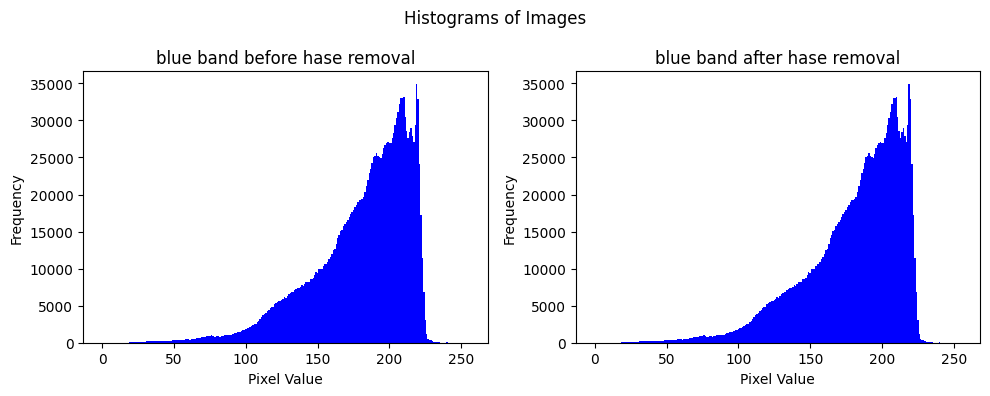

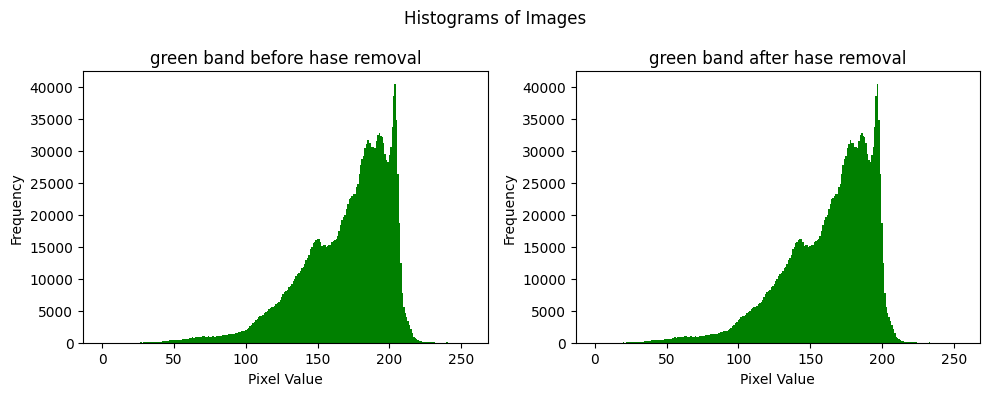

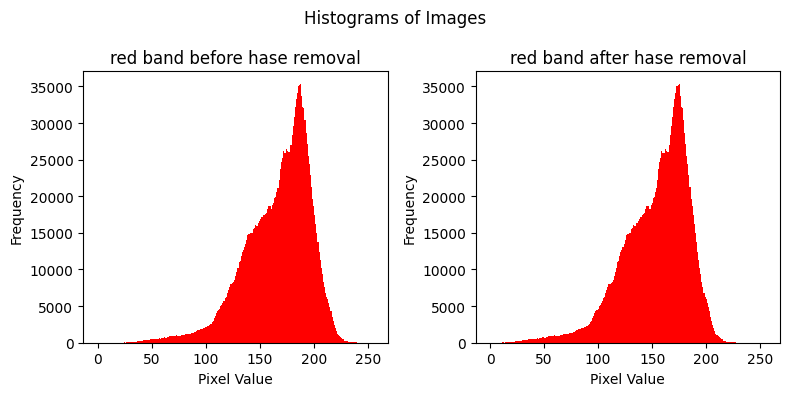

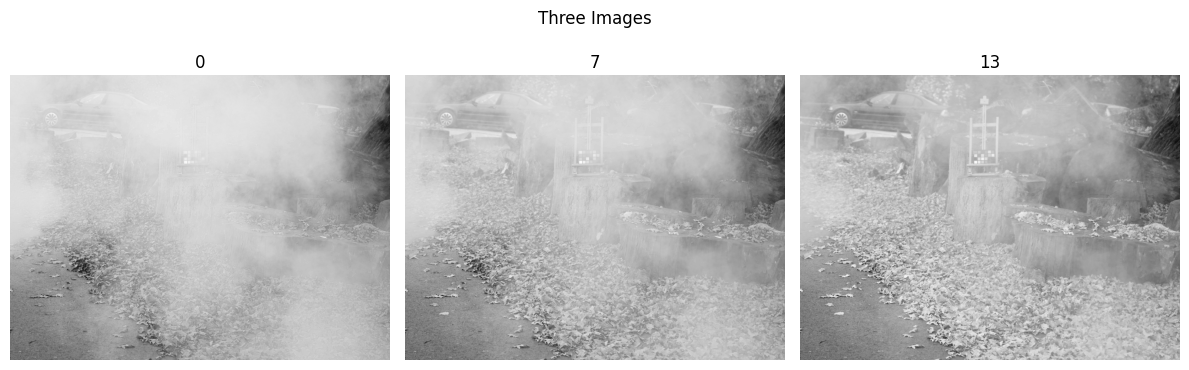

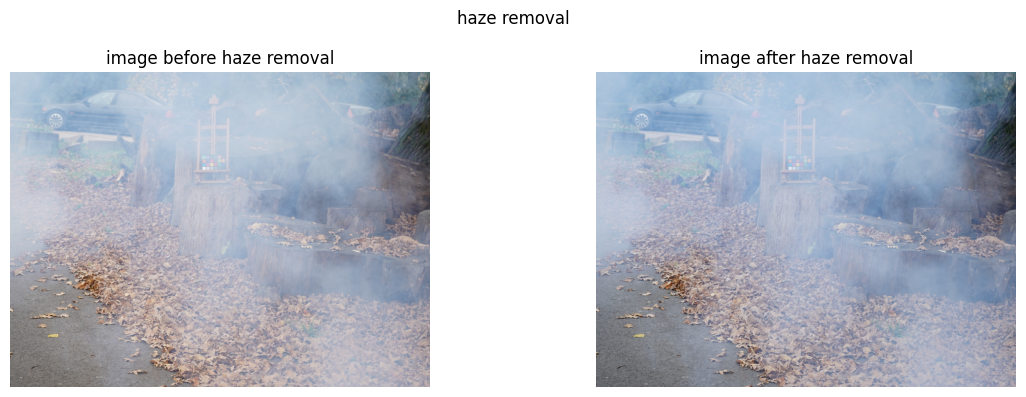

In [65]:
# use haze_img.png
image = cv2.imread('haze_img.png')
haze_removed_img = image.copy()
print(image.shape)

# Accessing each band
blue_band = image[:, :, 0]
green_band = image[:, :, 1]
red_band = image[:, :, 2]

# Finding the minimum value for each band
min_blue = np.min(blue_band)
min_green = np.min(green_band)
min_red = np.min(red_band)

haze_removed_img[:,:,0] -= min_blue
haze_removed_img[:,:,1] -= min_green
haze_removed_img[:,:,2] -= min_red
# haze_removed_img[:,:,0] -= 50
# haze_removed_img[:,:,1] -= 50
# haze_removed_img[:,:,2] -= 50

print("Minimum value in Blue Band:", min_blue)
print("Minimum value in Green Band:", min_green)
print("Minimum value in Red Band:", min_red)

# Accessing each band
blue_band1 = haze_removed_img[:, :, 0]
green_band1 = haze_removed_img[:, :, 1]
red_band1 = haze_removed_img[:, :, 2]

# Finding the minimum value for each band
min_blue1 = np.min(blue_band1)
min_green1 = np.min(green_band1)
min_red1 = np.min(red_band1)

print("Minimum value in Blue Band:", min_blue1)
print("Minimum value in Green Band:", min_green1)
print("Minimum value in Red Band:", min_red1)




histogram1, bins1 = np.histogram(blue_band.flatten(), bins=256, range=[0, 256])

histogram2, bins2 = np.histogram(blue_band1.flatten(), bins=256, range=[0, 256])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Histograms of Images')

# Plot the first histogram
ax1.bar(bins1[:-1], histogram1, width=1, color='blue')
ax1.set_title('blue band before hase removal')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')

# Plot the second histogram
ax2.bar(bins2[:-1], histogram2, width=1, color='blue')
ax2.set_title('blue band after hase removal')
ax2.set_xlabel('Pixel Value')
ax2.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

histogram1, bins1 = np.histogram(green_band.flatten(), bins=256, range=[0, 256])

histogram2, bins2 = np.histogram(green_band1.flatten(), bins=256, range=[0, 256])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Histograms of Images')

# Plot the first histogram
ax1.bar(bins1[:-1], histogram1, width=1, color='green')
ax1.set_title('green band before hase removal')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')

# Plot the second histogram
ax2.bar(bins2[:-1], histogram2, width=1, color='green')
ax2.set_title('green band after hase removal')
ax2.set_xlabel('Pixel Value')
ax2.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


histogram1, bins1 = np.histogram(red_band.flatten(), bins=256, range=[0, 256])

histogram2, bins2 = np.histogram(red_band1.flatten(), bins=256, range=[0, 256])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Histograms of Images')

# Plot the first histogram
ax1.bar(bins1[:-1], histogram1, width=1, color='red')
ax1.set_title('red band before hase removal')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')

# Plot the second histogram
ax2.bar(bins2[:-1], histogram2, width=1, color='red')
ax2.set_title('red band after hase removal')
ax2.set_xlabel('Pixel Value')
ax2.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()



# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Three Images')

# Plot the first image
ax1.imshow(blue_band1, cmap='gray')
ax1.set_title(str(min_blue))
ax1.axis('off')

# Plot the second image
ax2.imshow(green_band1, cmap='gray')
ax2.set_title(str(min_green))
ax2.axis('off')

# Plot the third image
ax3.imshow(red_band1, cmap='gray')
ax3.set_title(str(min_red))
ax3.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


# plt.imshow(cv2.cvtColor(haze_removed_img, cv2.COLOR_BGR2RGB))
# plt.title("new Image")
# plt.show()

# Create a figure with three subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('haze removal')

# Plot the first image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title("image before haze removal")
ax1.axis('off')

# Plot the second image
ax2.imshow(cv2.cvtColor(haze_removed_img, cv2.COLOR_BGR2RGB))
ax2.set_title("image after haze removal")
ax2.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
# cv2.imshow('Image', haze_removed_img)
# cv2.waitKey(0)

## Submission Instructions

To ensure a smooth evaluation process, please follow these steps for submitting your work:

1. **Prepare Your Submission:** Alongside your main notebook, include any additional files that are necessary for running the notebook successfully. This might include data files, images, or supplementary scripts.

2. **Rename Your Files:** Before submission, please rename your notebook to reflect the IDs of the two students working on this project. The format should be `ID1_ID2`, where `ID1` and `ID2` are the student IDs. For example, if the student IDs are `9123456` and `9876543`, then your notebook should be named `9123456_9876543.ipynb`.

3. **Check for Completeness:** Ensure that all required tasks are completed and that the notebook runs from start to finish without errors. This step is crucial for a smooth evaluation.

4. **Submit Your Work:** Once everything is in order, submit your notebook and any additional files via the designated submission link on Google Classroom **(code: 2yj6e24)**. Make sure you meet the submission deadline to avoid any late penalties.
5. Please, note that the same student should submit the assignments for the pair throughout the semester.

By following these instructions carefully, you help us in evaluating your work efficiently and fairly **and any failure to adhere to these guidelines can affect your grades**. If you encounter any difficulties or have questions about the submission process, please reach out as soon as possible.

We look forward to seeing your completed projects and wish you the best of luck!
